In [ ]:
# ============================================================
# MEMASANG DRIVE & INSTALL DEPENDENSI
# ============================================================

from google.colab import drive                                              #### Import modul drive dari Google Colab
import os                                                                   #### Import modul os untuk interaksi sistem operasi (misalnya, cek path)

drive.mount('/content/drive')                                               #### Pasang (mount) Google Drive ke direktori '/content/drive' di Colab

print("Instalasi dependensi. Mohon tunggu...")                              #### Pesan status instalasi
# Paket untuk ekstraksi PDF, OCR, NLP, ML + BARU: tqdm untuk progress bar, seaborn untuk visualisasi
!pip -q install PyPDF2 pdfminer.six Pillow pytesseract scikit-learn nltk pdf2image imbalanced-learn Sastrawi tqdm seaborn #### Instal paket Python yang dibutuhkan secara quietly (-q)
!apt-get -qq install -y tesseract-ocr tesseract-ocr-ind poppler-utils       #### Instal paket sistem (apt-get) untuk Tesseract OCR (mesin OCR) dan Poppler (utilitas PDF)
print("Instalasi selesai.")                                                 #### Pesan status bahwa instalasi selesai

Mounted at /content/drive
Instalasi dependensi. Mohon tunggu...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 15.5 MB/s eta 0:00:00
Selecting previously unselected package poppler-utils.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Selecting previously unselected package tesseract-ocr-ind.
Preparing to unpack .../tesseract-ocr-ind_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-ind (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-ind (1:4.00~git30-7274cfa-1.1) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...
Instalasi selesai.


In [ ]:
# ============================================================
# MENGIMPORT & KONFIGURASI GLOBAL
# ============================================================

import io                                                                   #### Import modul io (input/output) untuk bekerja dengan data dalam memori
import re                                                                   #### Import modul re (regular expression) untuk pembersihan teks
import warnings                                                             #### Import modul warnings
warnings.filterwarnings("ignore")                                           #### Mengabaikan semua pesan peringatan untuk output yang lebih bersih

import PyPDF2                                                               #### Import PyPDF2 untuk ekstraksi teks dari PDF
from pdfminer.high_level import extract_text_to_fp                          #### Import fungsi dari pdfminer.six untuk ekstraksi alternatif
from pdf2image import convert_from_path                                     #### Import fungsi untuk konversi PDF ke gambar (untuk OCR)
import pytesseract                                                          #### Import pytesseract untuk Optical Character Recognition (OCR)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory                  #### Import Sastrawi Stemmer Factory untuk stemming Bahasa Indonesia
import numpy as np                                                          #### Import numpy untuk operasi numerik array
import pandas as pd                                                         #### Import pandas untuk manipulasi data (DataFrame)
import matplotlib.pyplot as plt                                             #### Import matplotlib.pyplot untuk plotting dasar
import seaborn as sns                                                       #### Import seaborn (BARU) untuk visualisasi statistik yang lebih indah

# NLTK
import nltk                                                                 #### Import NLTK (Natural Language Toolkit)
nltk.download('punkt', quiet=True)                                          #### Unduh model tokenisasi 'punkt' secara quietly
nltk.download('stopwords', quiet=True)                                      #### Unduh daftar 'stopwords' secara quietly
from nltk.corpus import stopwords                                           #### Import daftar kata-kata penghubung (stopwords)
from nltk.tokenize import word_tokenize, wordpunct_tokenize                 #### Import tokenizer kata
from collections import Counter                                             #### Import Counter untuk menghitung frekuensi item

# BARU: Import tqdm untuk progress bar
from tqdm import tqdm                                                       #### Import tqdm untuk menampilkan progress bar saat pemrosesan dokumen

# Sklearn & Imblearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, learning_curve, cross_val_score #### Import modul seleksi dan validasi model
from sklearn.metrics import ( #### Import metrik evaluasi
    classification_report, confusion_matrix, ConfusionMatrixDisplay,        #### Laporan klasifikasi, matriks kebingungan, dan visualisasinya
    roc_curve, auc, precision_recall_curve, average_precision_score,        #### Metrik berbasis probabilitas (ROC, AUC, PR)
    accuracy_score                                                          #### Metrik akurasi
)
from sklearn.feature_extraction.text import TfidfVectorizer                 #### Import TF-IDF Vectorizer
from sklearn.decomposition import TruncatedSVD                              #### Import Truncated SVD (digunakan untuk LSI)
from sklearn.preprocessing import Normalizer, label_binarize                #### Import Normalizer dan label_binarize
from sklearn.pipeline import Pipeline                                       #### Import Pipeline untuk merangkai langkah pemrosesan
from sklearn.neighbors import KNeighborsClassifier                          #### Import K-Nearest Neighbors Classifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone              #### Import kelas dasar untuk membuat classifier kustom dan mengkloning model
from sklearn.metrics.pairwise import cosine_similarity                      #### Import cosine_similarity untuk menghitung kesamaan
from sklearn.calibration import CalibratedClassifierCV                      #### Import CalibratedClassifierCV untuk kalibrasi probabilitas

# Imblearn Samplers
from imblearn.over_sampling import SMOTE                                    #### Import SMOTE untuk oversampling data
# from imblearn.under_sampling import ClusterCentroids                              # TIDAK DIPAKAI LAGI #### Baris ini dikomentari (tidak digunakan)
from imblearn.pipeline import Pipeline as ImbPipeline                       #### Import Pipeline dari imblearn untuk menangani langkah sampling

# Inisialisasi Stemmer Sastrawi
stemmer = StemmerFactory().create_stemmer()                                 #### Buat objek stemmer Sastrawi untuk menormalkan kata

In [ ]:
# ============================================================
# LOKASI DATA & KONFIGURASI MODEL
# ============================================================

ROOT_DIR = '/content/drive/MyDrive/latih'                                   #### Definisikan lokasi folder root data dokumen PDF
SVD_COMPONENTS = 300                                                        #### Jumlah komponen Truncated SVD (LSI) yang akan digunakan
USE_OVERSAMPLING = True                                                     #### Flag untuk menentukan apakah SMOTE akan digunakan
STOP_ID = set(stopwords.words('indonesian'))                                #### Set daftar stop words Bahasa Indonesia

In [ ]:
# ============================================================
# EKSTRAKSI TEKS PDF
# ============================================================

def ekstrak_teks_pdf(pdf_path):                                             #### Definisikan fungsi untuk ekstraksi teks dari PDF
    teks_hasil = ""                                                         #### Inisialisasi variabel untuk menampung teks hasil
    # a) PyPDF2
    try:                                                                    #### Coba metode ekstraksi pertama (PyPDF2)
        with open(pdf_path, 'rb') as f:                                     #### Buka file PDF dalam mode binary read
            reader = PyPDF2.PdfReader(f)                                    #### Buat objek PdfReader
            for halaman in reader.pages:                                    #### Loop melalui setiap halaman
                t = halaman.extract_text()                                  #### Ekstrak teks dari halaman
                if t and t.strip():                                         #### Cek jika teks berhasil diekstrak
                    teks_hasil += t + "\n"                                  #### Gabungkan teks yang diekstrak
        if len(teks_hasil.strip()) > 50:                                    #### Jika total teks yang diekstrak signifikan
            return teks_hasil.strip()                                       #### Kembalikan teks dan selesai
    except:                                                                 #### Jika terjadi error di PyPDF2
        pass                                                                #### Lanjutkan ke metode berikutnya
    # b) pdfminer
    try:                                                                    #### Coba metode ekstraksi kedua (pdfminer.six)
        with open(pdf_path, 'rb') as infile:                                #### Buka file PDF dalam mode binary read
            out_str = io.StringIO()                                         #### Buat buffer memori untuk menampung output teks
            extract_text_to_fp(infile, out_str)                             #### Ekstrak teks ke buffer
            t = out_str.getvalue().strip()                                  #### Ambil teks dari buffer
            if t:                                                           #### Jika teks ditemukan
                return t                                                    #### Kembalikan teks dan selesai
    except:                                                                 #### Jika terjadi error di pdfminer
        pass                                                                #### Lanjutkan ke metode berikutnya
    # c) OCR
    try:                                                                    #### Coba metode ekstraksi ketiga (OCR/pytesseract)
        images = convert_from_path(pdf_path)                                #### Konversi PDF halaman per halaman menjadi gambar
        for img in images:                                                  #### Loop melalui setiap gambar (halaman)
            teks_hasil += pytesseract.image_to_string(img, lang='ind')      #### Lakukan OCR pada gambar dengan bahasa Indonesia
    except:                                                                 #### Jika terjadi error di OCR
        pass                                                                #### Lewati
    return teks_hasil.strip()                                               #### Kembalikan teks hasil OCR (mungkin kosong)

In [ ]:
# ============================================================
# PRA-PROSES TEKS
# ============================================================

def pra_proses_teks(teks: str) -> str:                                      #### Definisikan fungsi pra-pemrosesan teks
    teks = teks.lower()                                                     #### Konversi semua teks menjadi huruf kecil (case folding)
    teks = re.sub(r'[^\w\s]', ' ', teks)                                    #### Hapus semua tanda baca/karakter non-alphanumeric (kecuali spasi)
    teks = re.sub(r'\s+', ' ', teks).strip()                                #### Ganti multiple spasi menjadi single spasi dan hapus spasi di awal/akhir
    try:                                                                    #### Coba tokenisasi menggunakan nltk.word_tokenize
        tokens = word_tokenize(teks)                                        #### Tokenisasi kata
    except LookupError:                                                     #### Jika terjadi error
        tokens = wordpunct_tokenize(teks)                                   #### Gunakan tokenisasi alternatif
    tokens = [w for w in tokens if w not in STOP_ID and len(w) > 2]         #### Hapus stop words dan token yang panjangnya kurang dari 3
    teks_stemmed = stemmer.stem(" ".join(tokens))                           #### Lakukan stemming (mengubah kata berimbuhan ke kata dasar)
    return teks_stemmed                                                     #### Kembalikan teks yang sudah diproses

def tokens_namafile(path: str) -> str:                                      #### Fungsi untuk mengambil token dari nama file
    base = os.path.splitext(os.path.basename(path))[0]                      #### Ambil nama file tanpa ekstensi
    return re.sub(r'[_\-\.\$\$\$\$,]+', ' ', base)                          #### Ganti karakter non-alfanumerik umum dalam nama file dengan spasi

# DIMODIFIKASI: load_corpus dengan progress bar (tqdm), penanganan dokumen kosong, dan return tambahan untuk statistik
def load_corpus(root_dir):                                                  #### Fungsi untuk memuat korpus dari direktori
    paths, labels, texts = [], [], []                                       #### Inisialisasi list untuk path, label, dan teks
    if not os.path.exists(root_dir):                                        #### Cek apakah direktori root data ada
        raise SystemExit(f"[FATAL] ROOT_DIR not found: {root_dir}")         #### Keluar jika tidak ditemukan

    for main_cat in os.listdir(root_dir):                                   #### Loop melalui kategori utama (subfolder)
        main_path = os.path.join(root_dir, main_cat)                        #### Bentuk path ke kategori utama
        if not os.path.isdir(main_path):                                    #### Lewati jika bukan direktori
            continue                                                        #### Lanjutkan ke iterasi berikutnya
        for sub_cat in os.listdir(main_path):                               #### Loop melalui subkategori (subfolder)
            sub_path = os.path.join(main_path, sub_cat)                     #### Bentuk path ke subkategori
            if not os.path.isdir(sub_path):                                 #### Lewati jika bukan direktori
                continue                                                    #### Lanjutkan ke iterasi berikutnya
            for fn in os.listdir(sub_path):                                 #### Loop melalui file di dalam subkategori
                if fn.lower().endswith('.pdf'):                             #### Cek apakah file berakhiran .pdf
                    paths.append(os.path.join(sub_path, fn))                #### Simpan path file
                    labels.append(f"{main_cat}_{sub_cat}")                  #### Simpan label (gabungan kategori utama dan sub)

    print(f"Ditemukan {len(paths)} dokumen. Ekstraksi dan Pra-pemrosesan Teks...") #### Tampilkan jumlah dokumen yang ditemukan
    # BARU: Progress bar dengan tqdm untuk ekstraksi
    texts = []                                                                     #### Inisialisasi list untuk teks hasil ekstraksi
    for p in tqdm(paths, desc="Pemrosesan Dokumen", unit="it"):                    #### Loop dengan progress bar
        texts.append(ekstrak_teks_pdf(p))                                          #### Ekstrak teks untuk setiap path

    corpus, y = [], []                                                             #### Inisialisasi korpus (teks bersih) dan label akhir
    skipped = []                                                                   #### Inisialisasi list untuk melacak dokumen kosong
    for t, lab, p in zip(texts, labels, paths):                                    #### Loop melalui teks hasil ekstraksi, label, dan path
        if t and t.strip():                                                        #### Cek jika teks tidak kosong
            teks_final = t + " " + tokens_namafile(p)                              #### Gabungkan teks dan token nama file
            corpus.append(pra_proses_teks(teks_final))                             #### Pra-proses dan tambahkan ke korpus
            y.append(lab)                                                          #### Tambahkan label yang sesuai
        else:                                                                      #### Jika teks kosong
            skipped.append(os.path.basename(p))                                    #### Simpan nama file kosong

    # BARU: Tampilkan dokumen kosong yang dilewati
    for fn in skipped:                                                             #### Loop melalui dokumen yang dilewati
        print(f"Lewati dokumen kosong: {fn}")                                      #### Tampilkan pesan lewati

    cnt = Counter(y)                                                               #### Hitung frekuensi setiap label
    idx_keep = [i for i, lab in enumerate(y) if cnt[lab] > 1]                      #### Buat list indeks untuk label yang memiliki lebih dari 1 sampel
    corpus = [corpus[i] for i in idx_keep]                                         #### Filter korpus
    y = [y[i] for i in idx_keep]                                                   #### Filter label

    if len(y) == 0:                                                                #### Cek apakah korpus menjadi kosong setelah filter
        raise SystemExit("[FATAL] Korpus kosong setelah filter.")                  #### Keluar jika kosong
    print(f"\n{len(corpus)} dokumen siap dilatih ({len(set(y))} kategori)")        #### Tampilkan jumlah dokumen dan kategori akhir

    # BARU: Return tambahan untuk statistik (token lengths)
    token_lengths = [len(pra_proses_teks(c).split()) for c in corpus]              #### Hitung panjang token setiap dokumen
    return corpus, y, token_lengths                                                #### Kembalikan korpus, label, dan panjang token

In [ ]:
# ============================================================
# BARU: Fungsi untuk deskripsi data & visualisasi awal
# ============================================================

def deskripsi_dan_visualisasi(corpus, y, token_lengths):                           #### Fungsi untuk deskripsi dan visualisasi awal data
    print("\n=============================================")                       #### Batas pemisah
    print("| DESKRIPSI DATA & VISUALISASI AWAL |")                                 #### Judul
    print("=============================================")                         #### Batas pemisah

    total_docs = len(corpus)                                                       #### Jumlah total dokumen
    num_categories = len(set(y))                                                   #### Jumlah kategori unik
    print(f"Jumlah Total Dokumen: {total_docs}")                                   #### Tampilkan jumlah dokumen
    print(f"Jumlah Kategori: {num_categories}")                                    #### Tampilkan jumlah kategori

    freq = Counter(y)                                                              #### Hitung frekuensi kategori
    print("\nFrekuensi Kategori:")                                                 #### Judul frekuensi
    df_freq = pd.DataFrame.from_dict(freq, orient='index', columns=['Count']).sort_values('Count', ascending=False)   #### Buat DataFrame frekuensi
    print(df_freq.rename(index=lambda x: x.replace('_', ' ')))                                                        #### Tampilkan DataFrame (ganti '_' dengan spasi)

    # BARU: Grafik distribusi kategori (bar plot)
    plt.figure(figsize=(10, 6))                                                                                       #### Buat figure plot
    sns.barplot(data=df_freq.reset_index(), x='Count', y='index', palette='viridis')                                  #### Buat bar plot dengan seaborn
    plt.title('Distribusi Kategori Dokumen (Data Asli)')                                                              #### Judul plot
    plt.xlabel('Jumlah Dokumen')                                                                                      #### Label sumbu X
    plt.ylabel('Kategori')                                                                                            #### Label sumbu Y
    plt.tight_layout()                                                                                                #### Sesuaikan layout
    plt.show()                                                                                                        #### Tampilkan plot

    avg_tokens = np.mean(token_lengths)                                                                               #### Hitung rata-rata panjang token
    print(f"\nPanjang Token Rata-rata (Korpus): {avg_tokens:.2f}")                                                    #### Tampilkan rata-rata

    # BARU: Grafik distribusi jumlah token per dokumen (histogram)
    plt.figure(figsize=(10, 6))                                                                                       #### Buat figure plot
    plt.hist(token_lengths, bins=20, edgecolor='black', alpha=0.7)                                                    #### Buat histogram panjang token
    plt.title('Distribusi Jumlah Token per Dokumen')                                                                  #### Judul plot
    plt.xlabel('Jumlah Token')                                                                                        #### Label sumbu X
    plt.ylabel('Frekuensi')                                                                                           #### Label sumbu Y
    plt.axvline(avg_tokens, color='red', linestyle='--', label=f'Rata-rata: {avg_tokens:.2f}')                        #### Tambahkan garis rata-rata
    plt.legend()                                                                                                      #### Tampilkan legenda
    plt.tight_layout()                                                                                                #### Sesuaikan layout
    plt.show()                                                                                                        #### Tampilkan plot

In [ ]:
# ============================================================
# BARU: Visualisasi efek SMOTE dengan SVD 2D
# ============================================================

def visualisasi_efek_smote(corpus, y, n_components=2):                                                                #### Fungsi untuk visualisasi efek SMOTE dalam 2D
    print("[INFO] Memvisualisasikan efek SMOTE (SVD 2D)...")                                                          #### Pesan status

    tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=2)                                         #### Inisialisasi TF-IDF
    svd = TruncatedSVD(n_components=n_components, random_state=42)                                                    #### Inisialisasi SVD 2D

    # Sebelum SMOTE
    X_tfidf = tfidf.fit_transform(corpus)                                                                             #### Hitung dan transform TF-IDF
    X_svd_before = svd.fit_transform(X_tfidf)                                                                         #### Hitung dan transform SVD

    # Terapkan SMOTE
    smote = SMOTE(k_neighbors=1, random_state=42)                                                                     #### Inisialisasi SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)                                                         #### Terapkan SMOTE pada data TF-IDF
    X_svd_after = svd.transform(X_resampled)                                                                          #### Transform data resampled menggunakan SVD yang sama

    classes = sorted(set(y))                                                                                          #### Ambil daftar kelas
    colors = plt.cm.Set1(np.linspace(0, 1, len(classes)))                                                             #### Buat palet warna

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))                                                             #### Buat dua subplot

    # Plot sebelum SMOTE
    for i, cls in enumerate(classes):                                                                                 #### Loop untuk plot data sebelum SMOTE
        idx = [j for j, label in enumerate(y) if label == cls]                                                        #### Ambil indeks untuk kelas saat ini
        ax1.scatter(X_svd_before[idx, 0], X_svd_before[idx, 1], c=[colors[i]], label=cls, alpha=0.6)                  #### Plot data sebelum SMOTE
    ax1.set_title('Sebelum SMOTE (Imbalanced)')                                                                       #### Judul subplot 1
    ax1.legend()                                                                                                      #### Tampilkan legenda subplot 1

    # Plot sesudah SMOTE
    for i, cls in enumerate(classes):                                                                                 #### Loop untuk plot data setelah SMOTE
        idx = [j for j, label in enumerate(y_resampled) if label == cls]                                              #### Ambil indeks untuk kelas saat ini di data resampled
        ax2.scatter(X_svd_after[idx, 0], X_svd_after[idx, 1], c=[colors[i]], label=cls, alpha=0.6)                    #### Plot data setelah SMOTE
    ax2.set_title('Sesudah SMOTE (Balanced)')                                                                         #### Judul subplot 2
    ax2.legend()                                                                                                      #### Tampilkan legenda subplot 2

    plt.tight_layout()                                                                                                #### Sesuaikan layout
    plt.show()                                                                                                        #### Tampilkan plot

In [ ]:
# ============================================================
# KLASIFIKASI: LSI + COSINE (Centroid)
# ============================================================

class ClassCentroidCosineClassifier(BaseEstimator, ClassifierMixin):                                                  #### Definisikan kelas classifier kustom
    def __init__(self, use_softmax=True):                                                                             #### Konstruktor kelas
        self.use_softmax = use_softmax                                                                                #### Simpan parameter penggunaan softmax

    @staticmethod
    def _toarray(X):                                                                                                  #### Metode statis untuk mengkonversi sparse matrix ke array
        return X.toarray() if hasattr(X, "toarray") else X                                                            #### Konversi jika ada metode .toarray(), jika tidak, kembalikan X

    def fit(self, X, y):                                                                                              #### Metode untuk melatih classifier
        X = self._toarray(X)                                                                                          #### Pastikan X dalam bentuk array
        y = np.array(y)                                                                                               #### Pastikan y dalam bentuk array
        self.classes_ = np.unique(y)                                                                                  #### Simpan daftar kelas unik
        cents = []                                                                                                    #### List untuk menyimpan vektor centroid
        for c in self.classes_:                                                                                       #### Loop melalui setiap kelas
            Xi = X[y == c]                                                                                            #### Ambil semua sampel untuk kelas saat ini
            mu = Xi.mean(axis=0, keepdims=True)                                                                       #### Hitung vektor centroid (rata-rata)
            denom = np.linalg.norm(mu)                                                                                #### Hitung norm (panjang) vektor
            if denom > 0:                                                                                             #### Jika norm > 0
                mu = mu / denom                                                                                       #### Normalisasi vektor centroid
            cents.append(mu)                                                                                          #### Tambahkan centroid ke list
        self.centroids_ = np.vstack(cents)                                                                            #### Gabungkan semua centroid menjadi satu matriks
        return self                                                                                                   #### Kembalikan objek

    def decision_function(self, X):                                                                                   #### Metode untuk menghitung skor keputusan (kesamaan kosinus)
        X = self._toarray(X)                                                                                          #### Pastikan X dalam bentuk array
        return cosine_similarity(X, self.centroids_)                                                                  #### Hitung kesamaan kosinus antara sampel X dan centroid

    def predict(self, X):                                                                                             #### Metode untuk membuat prediksi kelas
        scores = self.decision_function(X)                                                                            #### Hitung skor kesamaan
        return self.classes_[np.argmax(scores, axis=1)]                                                               #### Kembalikan kelas dengan skor kesamaan tertinggi

    def predict_proba(self, X):                                                                                       #### Metode untuk memprediksi probabilitas kelas
        s = self.decision_function(X)                                                                                 #### Hitung skor kesamaan
        exp_s = np.exp(s - s.max(axis=1, keepdims=True))                                                              #### Aplikasikan eksponensial (untuk softmax)
        return exp_s / exp_s.sum(axis=1, keepdims=True)                                                               #### Hitung dan kembalikan probabilitas (softmax)

In [ ]:
# ------------------------------------------------------------
# PIPELINE PEMROSESAN (DIMODIFIKASI: Tambah info detail)
# ------------------------------------------------------------

def make_lsi_pipeline(classifier, n_components=SVD_COMPONENTS, oversample=USE_OVERSAMPLING):                          #### Fungsi untuk membuat pipeline LSI
    tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=2)                                         #### Inisialisasi TF-IDF Vectorizer
    svd = TruncatedSVD(n_components=n_components, random_state=42)                                                    #### Inisialisasi Truncated SVD (LSI)
    norm = Normalizer(copy=False)                                                                                     #### Inisialisasi Normalizer (normalisasi L2)

    if oversample:                                                                                                    #### Cek jika oversampling diaktifkan
        if 'KNeighborsClassifier' in classifier.__class__.__name__:                                                   #### Jika classifier adalah KNN
            print("[INFO] Pipeline KNN menggunakan SMOTE(k_neighbors=1).")                                            #### Pesan info SMOTE untuk KNN
            return ImbPipeline([                                                                                      #### Gunakan ImbPipeline untuk SMOTE
                ('tfidf', tfidf), ('svd', svd), ('norm', norm),                                                       #### Langkah-langkah preprocessing
                ('smote', SMOTE(k_neighbors=1, random_state=42)),                                                     #### Langkah SMOTE
                ('clf', classifier)                                                                                   #### Langkah classifier
            ])
        # PERUBAHAN UTAMA DI SINI: Centroid menggunakan Pipeline standar (tanpa ImbPipeline/sampling)
        elif 'ClassCentroidCosineClassifier' in classifier.__class__.__name__:                                        #### Jika classifier adalah Centroid Cosine
            print("[INFO] Pipeline Centroid Cosine: Tidak menggunakan SMOTE/sampling.")                               #### Pesan info tanpa sampling
            print("       Alasan: Centroid menghitung rata-rata vektor kelas yang ADA.")                              #### Alasan 1
            print("       SMOTE menambah sampel sintetik dan dapat menggeser posisi centroid.")                       #### Alasan 2
            return Pipeline([                                                                                         #### Gunakan Pipeline standar
                ('tfidf', tfidf), ('svd', svd), ('norm', norm),                                                       #### Langkah-langkah preprocessing
                ('clf', classifier)                                                                                   #### Langkah classifier
            ])
        else:                                                                                                         #### Untuk classifier lain jika oversample=True
            print("[INFO] Classifier lain: Pipeline standar.")                                                        #### Pesan info standar
            return Pipeline([('tfidf', tfidf), ('svd', svd), ('norm', norm), ('clf', classifier)])                    #### Pipeline standar tanpa SMOTE
    else:                                                                                                             #### Jika oversample=False
        return Pipeline([('tfidf', tfidf), ('svd', svd), ('norm', norm), ('clf', classifier)])                        #### Pipeline standar (tanpa SMOTE)


Ditemukan 353 dokumen. Ekstraksi dan Pra-pemrosesan Teks...


Pemrosesan Dokumen: 100%|██████████| 353/353 [26:26<00:00,  4.49s/it]


Lewati dokumen kosong: wan3.pdf

352 dokumen siap dilatih (13 kategori)

| DESKRIPSI DATA & VISUALISASI AWAL |
Jumlah Total Dokumen: 352
Jumlah Kategori: 13

Frekuensi Kategori:
                                Count
pendidikan pengujian mahasiswa     71
penelitian publikasi karya         59
pengabdian pembicara               53
penelitian paten,HKI               52
pengabdian pengabdian              35
pendidikan pengajaran              15
penunjang anggota profesi          14
pendidikan bahan ajar              13
penunjang penunjang lain           12
penelitian penelitian              11
pengabdian pengelola jurnal         7
pendidikan tugas tambahan           7
penunjang penghargaan               3


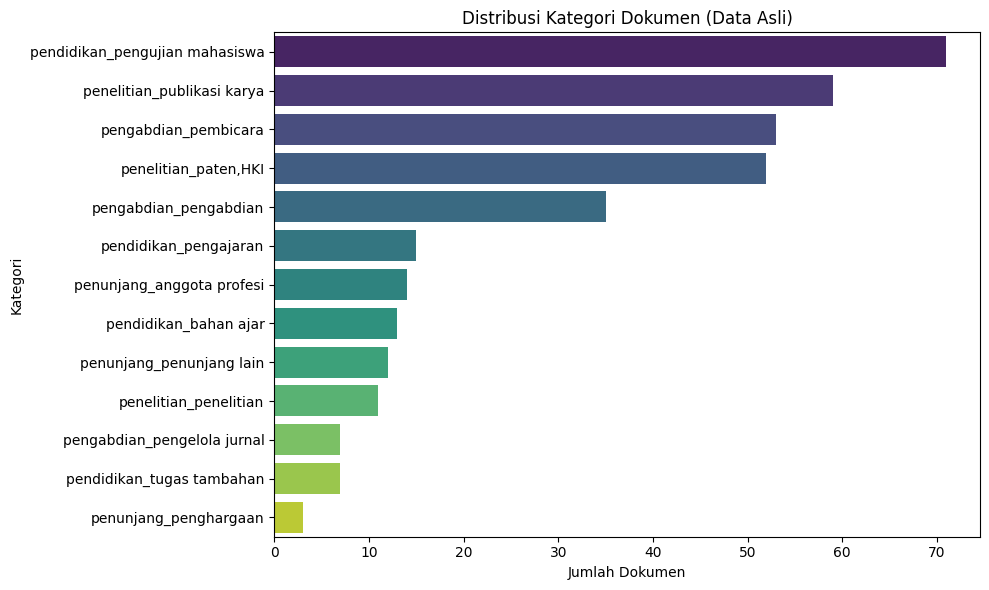


Panjang Token Rata-rata (Korpus): 1403.24


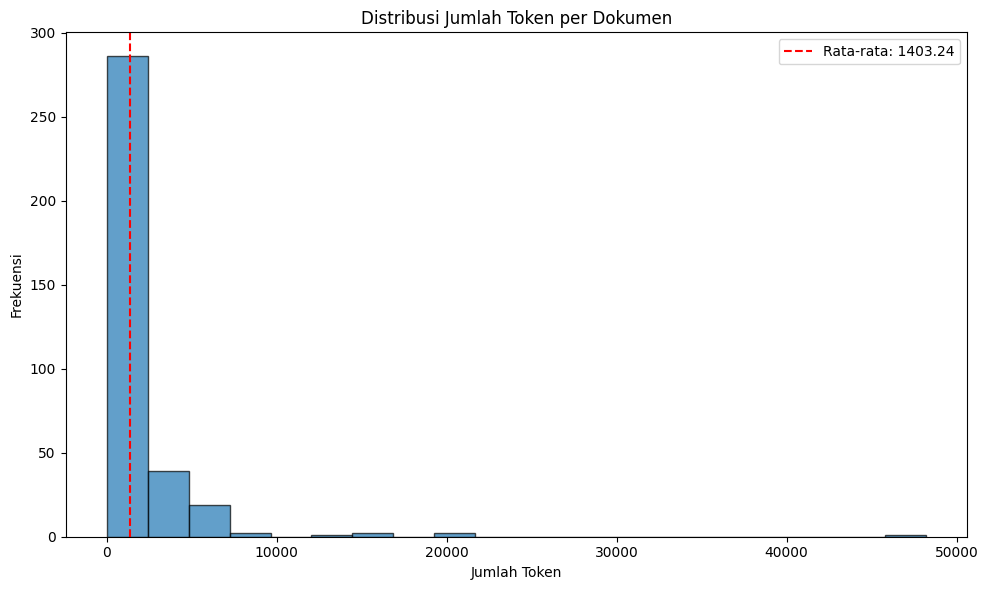

[INFO] Memvisualisasikan efek SMOTE (SVD 2D)...


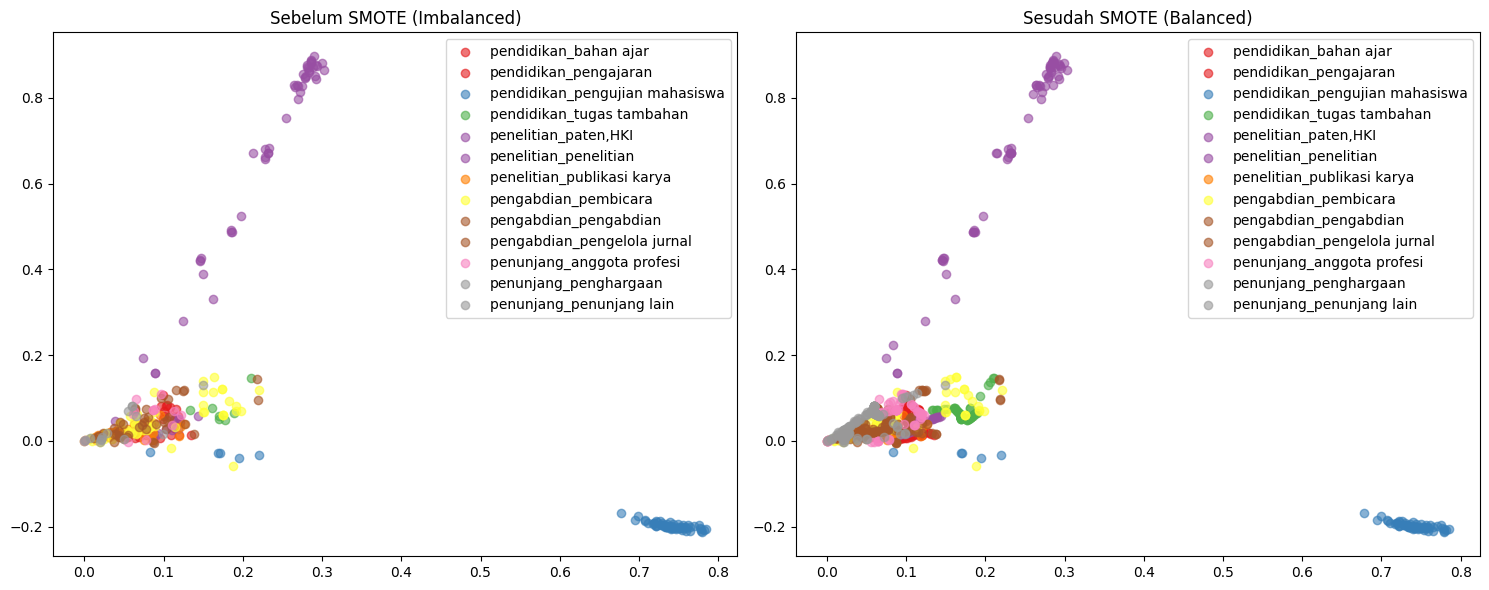

[INFO] Pipeline Centroid Cosine: Tidak menggunakan SMOTE/sampling.
       Alasan: Centroid menghitung rata-rata vektor kelas yang ADA.
       SMOTE menambah sampel sintetik dan dapat menggeser posisi centroid.
[INFO] Pipeline KNN menggunakan SMOTE(k_neighbors=1).

--- Konfigurasi Akhir ---
LSI Components: 300
CV Folds: 3 (min class=3)
-------------------------

=== GridSearch LSI+KNN (CV=3) ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params (KNN): {'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance'}
Best CV (F1-weighted): 0.8383


In [ ]:
# ============================================================
# MUAT DATA, CROSS VALIDATION, MODEL, DAN GRIDSEARCH KNN
# ============================================================

corpus_main, labels, token_lengths = load_corpus(ROOT_DIR)                                                            #### Muat korpus data (DIMODIFIKASI: Return token_lengths)
deskripsi_dan_visualisasi(corpus_main, labels, token_lengths)                                                         #### Panggil fungsi deskripsi dan visualisasi (BARU)

# BARU: Visualisasi efek SMOTE (hanya jika USE_OVERSAMPLING=True)
if USE_OVERSAMPLING:                                                                                                  #### Cek jika SMOTE diaktifkan
    visualisasi_efek_smote(corpus_main, labels)                                                                       #### Lakukan visualisasi efek SMOTE

classes = sorted(set(labels))                                                                                         #### Ambil daftar kelas yang sudah diurutkan
min_class = min(Counter(labels).values())                                                                             #### Hitung jumlah sampel di kelas terkecil

# Minimal 2 fold, maksimal 5 fold, dan tidak lebih dari jumlah data terkecil
cv_folds = max(2, min(5, min_class))                                                                                  #### Hitung jumlah fold CV (antara 2 dan 5, max min_class)
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)                                                #### Inisialisasi Stratified K-Fold CV

pipe_cos = make_lsi_pipeline(ClassCentroidCosineClassifier(use_softmax=True))                                         #### Buat pipeline LSI+Cosine
knn_base = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)                                               #### Inisialisasi KNN classifier dasar
pipe_knn_base = make_lsi_pipeline(knn_base)                                                                           #### Buat pipeline LSI+KNN

# DIMODIFIKASI: Pesan konfigurasi akhir
print(f"\n--- Konfigurasi Akhir ---")                                                                                 #### Judul konfigurasi
print(f"LSI Components: {SVD_COMPONENTS}")                                                                            #### Tampilkan jumlah komponen LSI
print(f"CV Folds: {cv_folds} (min class={min_class})")                                                                #### Tampilkan jumlah fold CV
print("-------------------------\n")                                                                                  #### Batas pemisah

param_grid = {                                                                                                        #### Definisikan grid parameter untuk GridSearch KNN
    'clf__n_neighbors': [3, 5, 7, 9, 11],                                                                             #### Jumlah tetangga (K)
    'clf__weights': ['uniform', 'distance'],                                                                          #### Tipe bobot tetangga
    'clf__p': [1, 2],                                                                                                 #### Parameter metrik jarak (1=Manhattan, 2=Euclidean)
}

print(f"=== GridSearch LSI+KNN (CV={cv_folds}) ===")                                                                  #### Judul GridSearch
gs_knn = GridSearchCV(                                                                                                #### Inisialisasi GridSearchCV
    pipe_knn_base,                                                                                                    #### Pipeline yang akan diuji
    param_grid=param_grid,                                                                                            #### Grid parameter
    cv=cv,                                                                                                            #### Strategi cross-validation
    scoring='f1_weighted',                                                                                            #### Metrik skor yang dioptimalkan
    n_jobs=-1,                                                                                                        #### Gunakan semua core CPU
    verbose=1                                                                                                         #### Tampilkan proses
)
gs_knn.fit(corpus_main, labels)                                                                                       #### Jalankan GridSearch (latih model)
best_model_knn = gs_knn.best_estimator_                                                                               #### Ambil model terbaik dari hasil GridSearch

# DIMODIFIKASI: Output best params lebih mirip contoh
print(f"Best params (KNN): {gs_knn.best_params_}")                                                                    #### Tampilkan parameter terbaik
print(f"Best CV (F1-weighted): {gs_knn.best_score_:.4f}")                                                             #### Tampilkan skor terbaik



| EVALUASI: LSI+Cosine Similarity (Centroid) |
Akurasi (CV): 0.8523
                                precision    recall  f1-score   support

         pendidikan_bahan ajar       0.76      1.00      0.87        13
         pendidikan_pengajaran       0.88      0.93      0.90        15
pendidikan_pengujian mahasiswa       0.99      1.00      0.99        71
     pendidikan_tugas tambahan       0.78      1.00      0.88         7
          penelitian_paten,HKI       1.00      0.94      0.97        52
         penelitian_penelitian       0.52      1.00      0.69        11
    penelitian_publikasi karya       0.85      0.76      0.80        59
          pengabdian_pembicara       0.85      0.74      0.79        53
         pengabdian_pengabdian       0.75      0.77      0.76        35
   pengabdian_pengelola jurnal       0.80      0.57      0.67         7
     penunjang_anggota profesi       0.73      0.79      0.76        14
         penunjang_penghargaan       0.75      1.00      0.86     

<Figure size 1000x800 with 0 Axes>

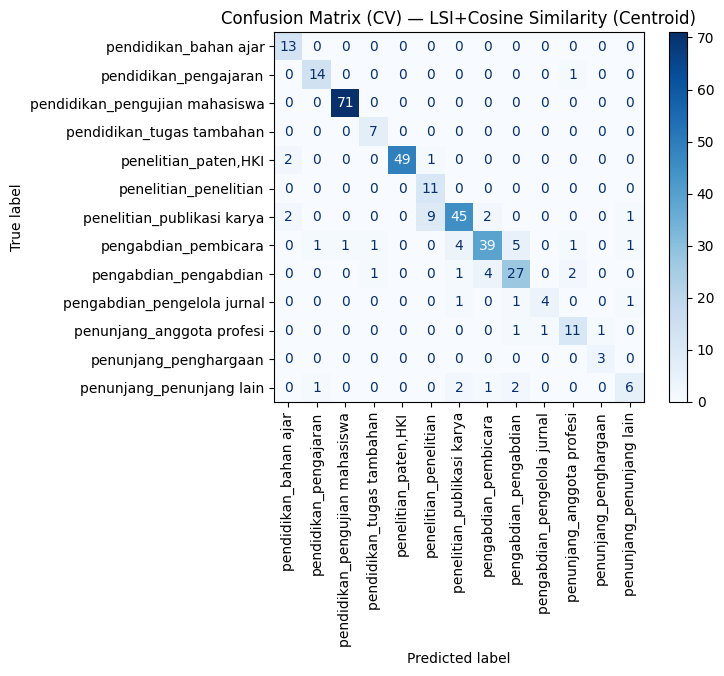

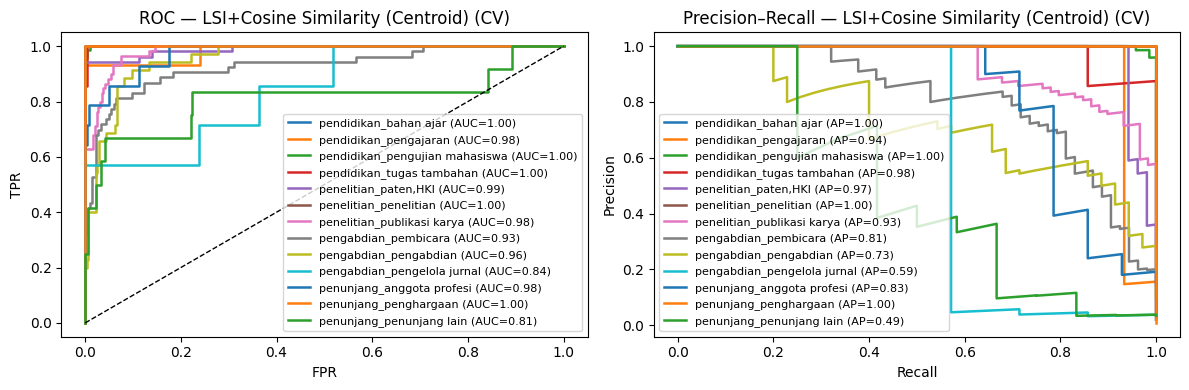


| EVALUASI: LSI+KNN (K=3) |
Akurasi (CV): 0.8381
                                precision    recall  f1-score   support

         pendidikan_bahan ajar       0.76      1.00      0.87        13
         pendidikan_pengajaran       0.93      0.93      0.93        15
pendidikan_pengujian mahasiswa       0.99      1.00      0.99        71
     pendidikan_tugas tambahan       0.78      1.00      0.88         7
          penelitian_paten,HKI       0.98      0.94      0.96        52
         penelitian_penelitian       0.69      1.00      0.81        11
    penelitian_publikasi karya       0.88      0.83      0.85        59
          pengabdian_pembicara       0.86      0.68      0.76        53
         pengabdian_pengabdian       0.69      0.63      0.66        35
   pengabdian_pengelola jurnal       1.00      0.43      0.60         7
     penunjang_anggota profesi       0.55      0.79      0.65        14
         penunjang_penghargaan       0.75      1.00      0.86         3
      penunja

<Figure size 1000x800 with 0 Axes>

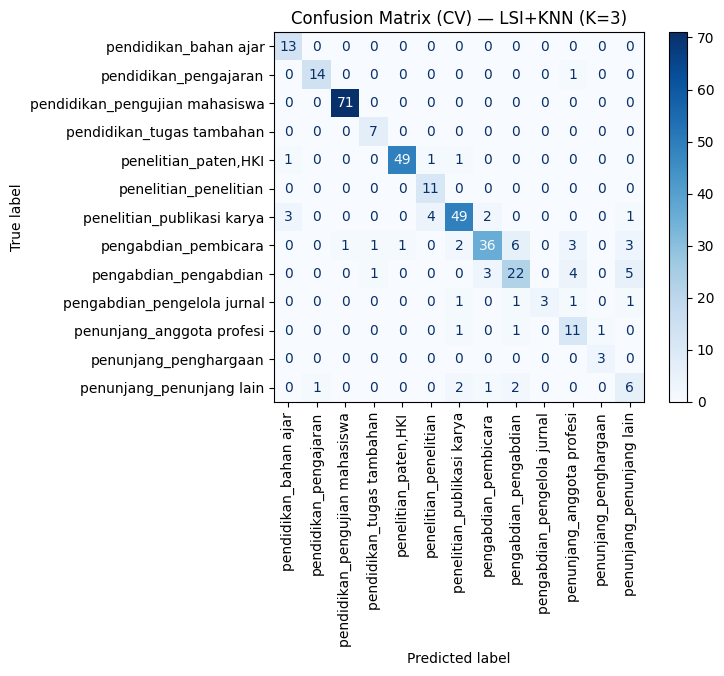

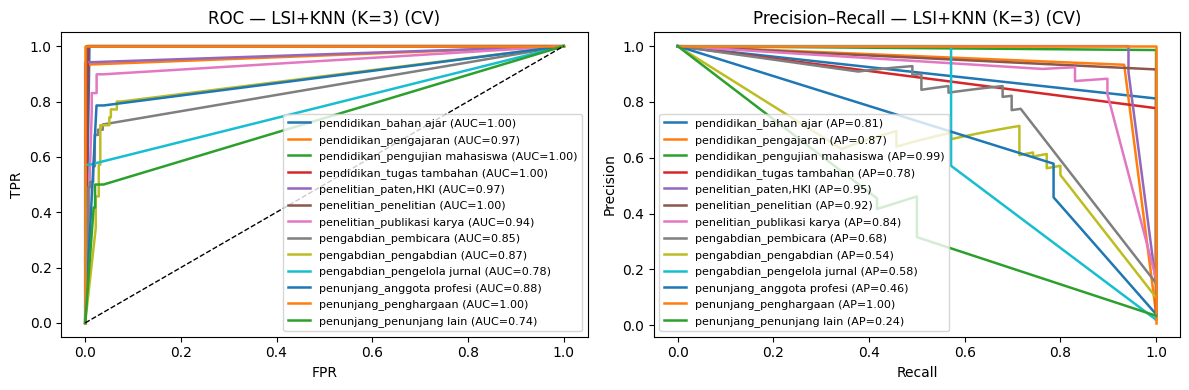



| RINGKASAN HASIL EVALUASI KOMPARATIF (CV) |
                                  Accuracy F1-Weighted AUC-Macro  AP-Macro
LSI+Cosine Similarity (Centroid)  0.852273    0.852175  0.958767  0.866351
LSI+KNN (K=3)                     0.838068    0.838704  0.921791  0.743728


In [ ]:
# ============================================================
# EVALUASI UTAMA: Confusion Matrix, ROC & Precision-Recall
# ============================================================

models = {                                                                                                            #### Definisikan dictionary model yang akan dievaluasi
    "LSI+Cosine Similarity (Centroid)": pipe_cos,                                                                     #### Model Cosine Centroid
    f"LSI+KNN (K={best_model_knn.named_steps['clf'].n_neighbors})": best_model_knn                                    #### Model KNN terbaik
}

summary_df = pd.DataFrame(                                                                                            #### Buat DataFrame untuk ringkasan hasil
    index=models.keys(),                                                                                              #### Gunakan nama model sebagai indeks
    columns=['Accuracy', 'F1-Weighted', 'AUC-Macro', 'AP-Macro']                                                      #### Kolom metrik
)


def evaluate_and_plot(name, model, X, y, classes, cv):                                                                #### Fungsi untuk mengevaluasi dan memplot model
    print("\n" + "=" * 56)                                                                                            #### Batas pemisah
    print(f"| EVALUASI: {name} |")                                                                                    #### Judul evaluasi
    print("=" * 56)                                                                                                   #### Batas pemisah

    y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)                                                      #### Lakukan prediksi CV (hasil prediksi)
    acc = accuracy_score(y, y_pred_cv)                                                                                #### Hitung akurasi
    print(f"Akurasi (CV): {acc:.4f}")                                                                                 #### Tampilkan akurasi
    print(classification_report(y, y_pred_cv, zero_division=0))                                                       #### Tampilkan laporan klasifikasi

    rep = classification_report(y, y_pred_cv, output_dict=True, zero_division=0)                                      #### Ambil laporan klasifikasi dalam bentuk dictionary
    f1_w = rep['weighted avg']['f1-score']                                                                            #### Ambil skor F1-Weighted

    cm = confusion_matrix(y, y_pred_cv, labels=classes)                                                               #### Hitung confusion matrix
    plt.figure(figsize=(10, 8))                                                                                       #### Buat figure plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)                                        #### Buat objek untuk tampilan CM
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')                                       #### Plot CM
    plt.title(f'Confusion Matrix (CV) — {name}')                                                                      #### Judul plot
    plt.show()                                                                                                        #### Tampilkan plot

    auc_macro = np.nan                                                                                                #### Inisialisasi AUC Macro
    ap_macro = np.nan                                                                                                 #### Inisialisasi AP Macro
    try:                                                                                                              #### Coba hitung metrik berbasis probabilitas
        y_proba_cv = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)                         #### Prediksi CV (hasil probabilitas)
        y_bin = label_binarize(y, classes=classes)                                                                    #### Binarisasi label kelas

        # ROC Curve
        plt.figure(figsize=(12, 4))                                                                                   #### Buat figure untuk ROC dan PR
        ax1 = plt.subplot(1, 2, 1)                                                                                    #### Subplot 1 (ROC)
        aucs = []                                                                                                     #### List untuk AUC per kelas
        for i, cls in enumerate(classes):                                                                             #### Loop melalui setiap kelas
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_cv[:, i])                                                    #### Hitung ROC curve
            roc_auc = auc(fpr, tpr)                                                                                   #### Hitung AUC
            aucs.append(roc_auc)                                                                                      #### Simpan AUC
            ax1.plot(fpr, tpr, lw=1.8, label=f"{cls} (AUC={roc_auc:.2f})")                                            #### Plot ROC curve
        ax1.plot([0, 1], [0, 1], 'k--', lw=1)                                                                         #### Plot garis diagonal (random)
        ax1.set_xlabel("FPR")                                                                                         #### Label sumbu X
        ax1.set_ylabel("TPR")                                                                                         #### Label sumbu Y
        ax1.set_title(f"ROC — {name} (CV)")                                                                           #### Judul plot
        ax1.legend(fontsize=8, loc="lower right")                                                                     #### Tampilkan legenda

        # Precision-Recall Curve
        ax2 = plt.subplot(1, 2, 2)                                                                                    #### Subplot 2 (Precision-Recall)
        aps = []                                                                                                      #### List untuk AP per kelas
        for i, cls in enumerate(classes):                                                                             #### Loop melalui setiap kelas
            p, r, _ = precision_recall_curve(y_bin[:, i], y_proba_cv[:, i])                                           #### Hitung Precision-Recall curve
            ap = average_precision_score(y_bin[:, i], y_proba_cv[:, i])                                               #### Hitung Average Precision (AP)
            aps.append(ap)                                                                                            #### Simpan AP
            ax2.plot(r, p, lw=1.8, label=f"{cls} (AP={ap:.2f})")                                                      #### Plot PR curve
        ax2.set_xlabel("Recall")                                                                                      #### Label sumbu X
        ax2.set_ylabel("Precision")                                                                                   #### Label sumbu Y
        ax2.set_title(f"Precision–Recall — {name} (CV)")                                                              #### Judul plot
        ax2.legend(fontsize=8, loc="lower left")                                                                      #### Tampilkan legenda

        plt.tight_layout()                                                                                            #### Sesuaikan layout
        plt.show()                                                                                                    #### Tampilkan plot

        auc_macro = float(np.mean(aucs))                                                                              #### Hitung rata-rata AUC (macro average)
        ap_macro = float(np.mean(aps))                                                                                #### Hitung rata-rata AP (macro average)
    except Exception as e:                                                                                            #### Tangani error jika terjadi
        print(f"[WARN] ROC/PR dilewati untuk {name}: {e!r}")                                                          #### Pesan peringatan

    return acc, f1_w, auc_macro, ap_macro                                                                             #### Kembalikan metrik

for name, model in models.items():                                                                                    #### Loop melalui setiap model yang dievaluasi
    acc, f1w, aucm, apm = evaluate_and_plot(name, model, corpus_main, labels, classes, cv)                            #### Jalankan evaluasi
    summary_df.loc[name, 'Accuracy'] = acc                                                                            #### Simpan Akurasi di DataFrame
    summary_df.loc[name, 'F1-Weighted'] = f1w                                                                         #### Simpan F1-Weighted di DataFrame
    summary_df.loc[name, 'AUC-Macro'] = aucm                                                                          #### Simpan AUC-Macro di DataFrame
    summary_df.loc[name, 'AP-Macro'] = apm                                                                            #### Simpan AP-Macro di DataFrame

print("\n\n========================================================")                                                 #### Batas pemisah
print("| RINGKASAN HASIL EVALUASI KOMPARATIF (CV) |")                                                                 #### Judul ringkasan
print("========================================================")                                                     #### Batas pemisah
print(summary_df)                                                                                                     #### Tampilkan DataFrame ringkasan

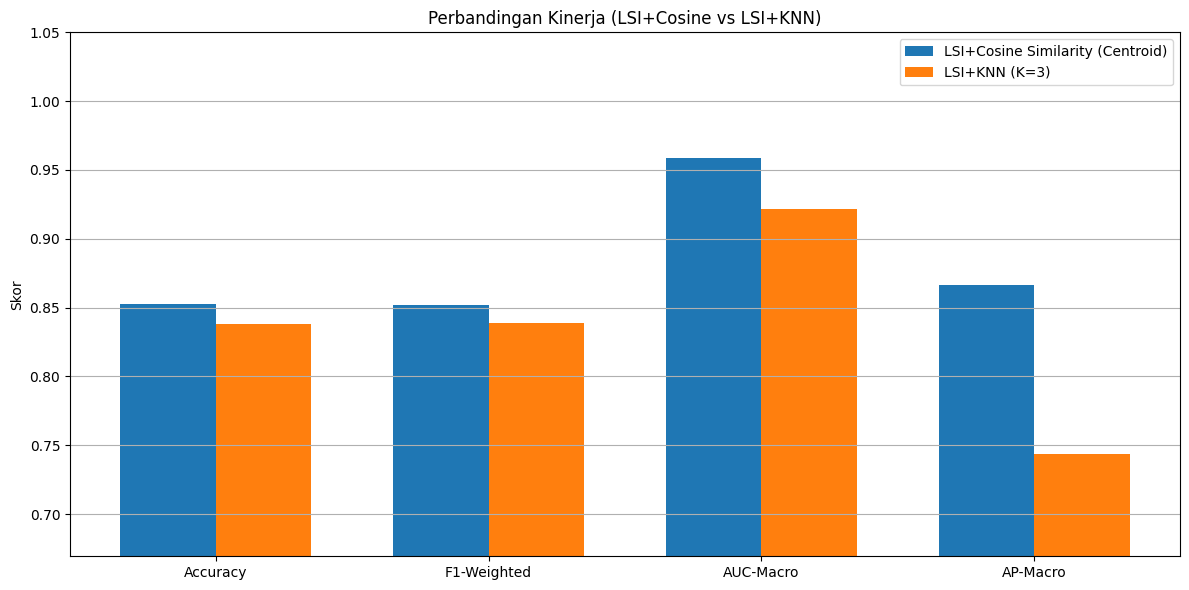

In [ ]:
# ============================================================
# BAR PLOT RINGKASAN
# ============================================================

metrics = ['Accuracy', 'F1-Weighted', 'AUC-Macro', 'AP-Macro']                                                        #### Daftar metrik yang akan diplot
x = np.arange(len(metrics))                                                                                           #### Posisi untuk label x (metrik)
width = 0.35                                                                                                          #### Lebar setiap bar

fig, ax = plt.subplots(figsize=(12, 6))                                                                               #### Buat figure dan axes plot
row0 = pd.to_numeric(summary_df.iloc[0][metrics], errors='coerce').astype(float).values                               #### Ambil skor model 1
row1 = pd.to_numeric(summary_df.iloc[1][metrics], errors='coerce').astype(float).values                               #### Ambil skor model 2

ax.bar(x - width / 2, row0, width, label=summary_df.index[0])                                                         #### Plot bar untuk model 1
ax.bar(x + width / 2, row1, width, label=summary_df.index[1])                                                         #### Plot bar untuk model 2

ax.set_ylabel('Skor')                                                                                                 #### Label sumbu Y
ax.set_title('Perbandingan Kinerja (LSI+Cosine vs LSI+KNN)')                                                          #### Judul plot
ax.set_xticks(x)                                                                                                      #### Set posisi tick x
ax.set_xticklabels(metrics)                                                                                           #### Set label tick x
ax.legend()                                                                                                           #### Tampilkan legenda
ax.grid(axis='y')                                                                                                     #### Tambahkan grid pada sumbu Y

yall = np.concatenate([row0, row1])                                                                                   #### Gabungkan semua skor
ymin = max(0.0, np.nanmin(yall) * 0.9)                                                                                #### Hitung batas bawah sumbu Y
plt.ylim(ymin, 1.05)                                                                                                  #### Set batas sumbu Y
plt.tight_layout()                                                                                                    #### Sesuaikan layout
plt.show()                                                                                                            #### Tampilkan plot

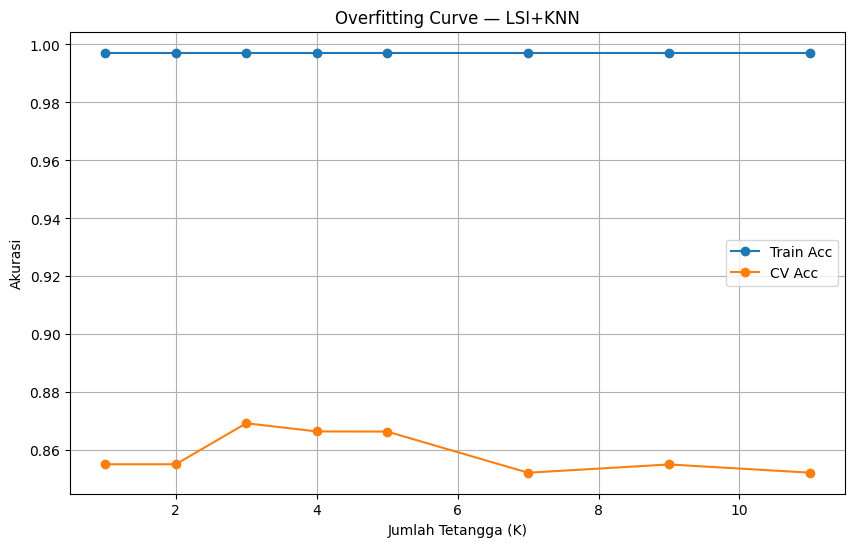

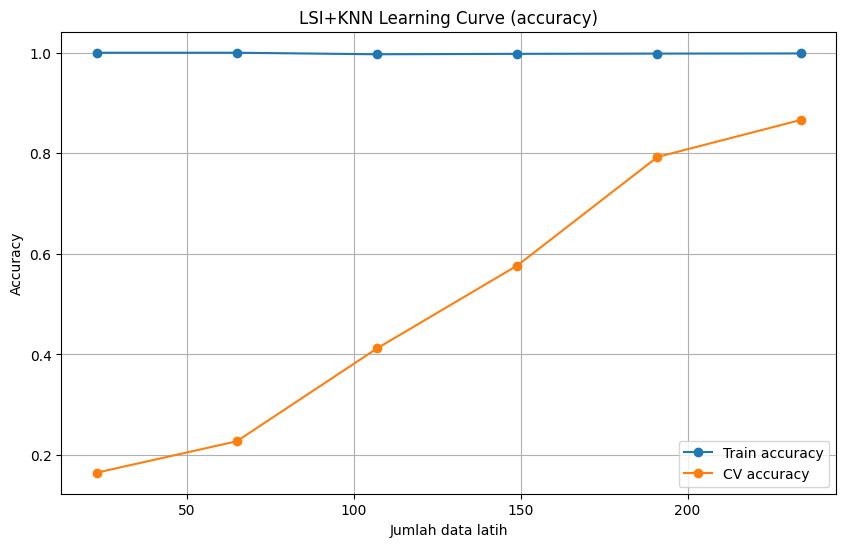

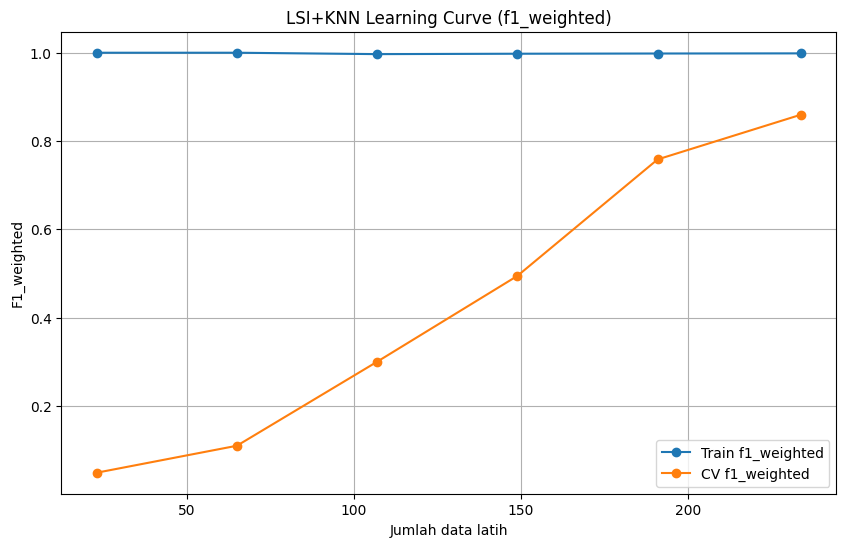

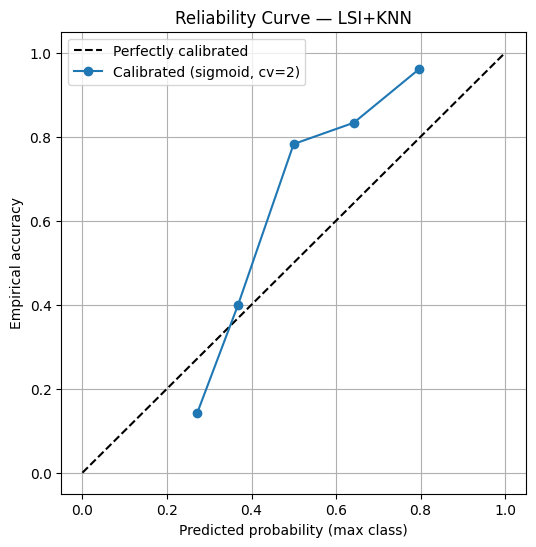

In [ ]:
# ============================================================
# GRAFIK TAMBAHAN: Overfitting, Learning Curve, Reliability
# ============================================================

# Catatan: pipe_knn_no_sampling di bawah menggunakan `oversample=False` yang berarti tanpa SMOTE
pipe_knn_no_sampling = make_lsi_pipeline(                                                                             #### Buat pipeline KNN tanpa SMOTE
    KNeighborsClassifier(n_neighbors=5, weights='distance', p=2),                                                     #### Classifier KNN
    n_components=SVD_COMPONENTS,                                                                                      #### Jumlah komponen LSI
    oversample=False                                                                                                  #### Set oversample ke False
)

# a) Overfitting curve untuk KNN
ks = [1, 2, 3, 4, 5, 7, 9, 11]                                                                                        #### Daftar nilai K yang akan diuji
train_acc, cv_acc = [], []                                                                                            #### List untuk menyimpan akurasi train dan CV
for k in ks:                                                                                                          #### Loop melalui nilai K
    mdl = clone(pipe_knn_no_sampling)                                                                                 #### Kloning pipeline dasar
    mdl.named_steps['clf'].n_neighbors = k                                                                            #### Ubah nilai K
    mdl.fit(corpus_main, labels) #### Latih model
    train_acc.append(accuracy_score(labels, mdl.predict(corpus_main)))                                                #### Hitung dan simpan akurasi train
    cv_acc.append(cross_val_score(mdl, corpus_main, labels, cv=cv, scoring='accuracy', n_jobs=-1).mean())             #### Hitung dan simpan rata-rata akurasi CV

plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(ks, train_acc, marker='o', label='Train Acc')                                                                #### Plot akurasi train
plt.plot(ks, cv_acc, marker='o', label='CV Acc')                                                                      #### Plot akurasi CV
plt.title('Overfitting Curve — LSI+KNN')                                                                              #### Judul plot
plt.xlabel('Jumlah Tetangga (K)')                                                                                     #### Label sumbu X
plt.ylabel('Akurasi')                                                                                                 #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# b) Learning curve (accuracy) untuk KNN
train_sizes = np.linspace(0.1, 1.0, 6)                                                                                #### Daftar ukuran data latih (proporsi)
tr_sizes, tr_scores, cv_scores = learning_curve(                                                                      #### Hitung learning curve
    estimator=pipe_knn_no_sampling,                                                                                   #### Estimator
    X=corpus_main,                                                                                                    #### Data X
    y=labels,                                                                                                         #### Data Y
    train_sizes=train_sizes,                                                                                          #### Ukuran data latih
    cv=cv,                                                                                                            #### Strategi CV
    scoring='accuracy',                                                                                               #### Metrik skor
    n_jobs=-1                                                                                                         #### Gunakan semua core
)
plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(tr_sizes, tr_scores.mean(axis=1), marker='o', label='Train accuracy')                                        #### Plot akurasi train
plt.plot(tr_sizes, cv_scores.mean(axis=1), marker='o', label='CV accuracy')                                           #### Plot akurasi CV
plt.title('LSI+KNN Learning Curve (accuracy)')                                                                        #### Judul plot
plt.xlabel('Jumlah data latih')                                                                                       #### Label sumbu X
plt.ylabel('Accuracy')                                                                                                #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# c) Learning curve (f1_weighted) untuk KNN
tr_sizes, tr_scores, cv_scores = learning_curve(                                                                      #### Hitung learning curve (f1_weighted)
    estimator=pipe_knn_no_sampling,                                                                                   #### Estimator
    X=corpus_main,                                                                                                    #### Data X
    y=labels,                                                                                                         #### Data Y
    train_sizes=train_sizes,                                                                                          #### Ukuran data latih
    cv=cv,                                                                                                            #### Strategi CV
    scoring='f1_weighted',                                                                                            #### Metrik skor
    n_jobs=-1                                                                                                         #### Gunakan semua core
)
plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(tr_sizes, tr_scores.mean(axis=1), marker='o', label='Train f1_weighted')                                     #### Plot F1 train
plt.plot(tr_sizes, cv_scores.mean(axis=1), marker='o', label='CV f1_weighted')                                        #### Plot F1 CV
plt.title('LSI+KNN Learning Curve (f1_weighted)')                                                                     #### Judul plot
plt.xlabel('Jumlah data latih')                                                                                       #### Label sumbu X
plt.ylabel('F1_weighted')                                                                                             #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# d) Reliability / Calibration curve untuk KNN
calib = CalibratedClassifierCV(estimator=pipe_knn_no_sampling, method='sigmoid', cv=2)                                #### Inisialisasi CalibratedClassifierCV (metode sigmoid, 2 CV)
y_proba_cal = cross_val_predict(calib, corpus_main, labels, cv=cv, method='predict_proba', n_jobs=-1)                 #### Prediksi probabilitas kalibrasi CV
y_pred = np.argmax(y_proba_cal, axis=1)                                                                               #### Ambil kelas prediksi
labels_arr = np.array([classes.index(c) for c in labels])                                                             #### Konversi label ke indeks numerik
max_proba = y_proba_cal[np.arange(len(y_proba_cal)), y_pred]                                                          #### Ambil probabilitas tertinggi (y_pred)
correct = (y_pred == labels_arr).astype(int)                                                                          #### Cek apakah prediksi benar (1 atau 0)

bins = np.linspace(0.0, 1.0, 8)                                                                                       #### Definisikan batas bin (8 bin)
bin_ids = np.digitize(max_proba, bins) - 1                                                                            #### Tentukan bin ID untuk setiap probabilitas
x_bin, y_bin = [], []                                                                                                 #### List untuk menyimpan titik plot kalibrasi
for b in range(len(bins) - 1):                                                                                        #### Loop melalui setiap bin
    idx = (bin_ids == b)                                                                                              #### Ambil indeks sampel di bin ini
    if idx.sum() == 0:                                                                                                #### Jika bin kosong
        continue                                                                                                      #### Lanjutkan ke bin berikutnya
    x_bin.append(max_proba[idx].mean())                                                                               #### Rata-rata probabilitas prediksi (sumbu X)
    y_bin.append(correct[idx].mean())                                                                                 #### Rata-rata akurasi empiris (sumbu Y)

plt.figure(figsize=(6, 6))                                                                                            #### Buat figure plot
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')                                                         #### Plot garis kalibrasi sempurna
plt.plot(x_bin, y_bin, marker='o', label='Calibrated (sigmoid, cv=2)')                                                #### Plot reliability curve
plt.xlabel('Predicted probability (max class)')                                                                       #### Label sumbu X
plt.ylabel('Empirical accuracy')                                                                                      #### Label sumbu Y
plt.title('Reliability Curve — LSI+KNN')                                                                              #### Judul plot
plt.legend()                                                                                                          #### Tampilkan legenda
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.show()                                                                                                            #### Tampilkan plot

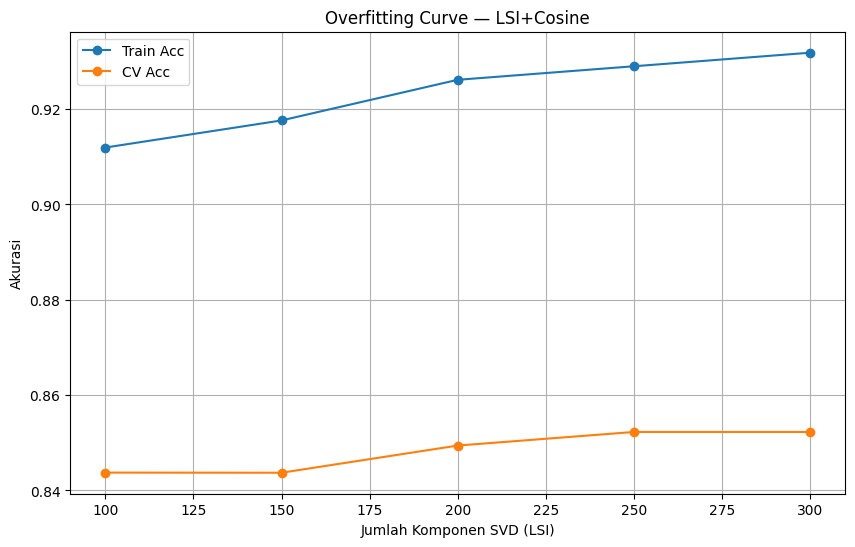

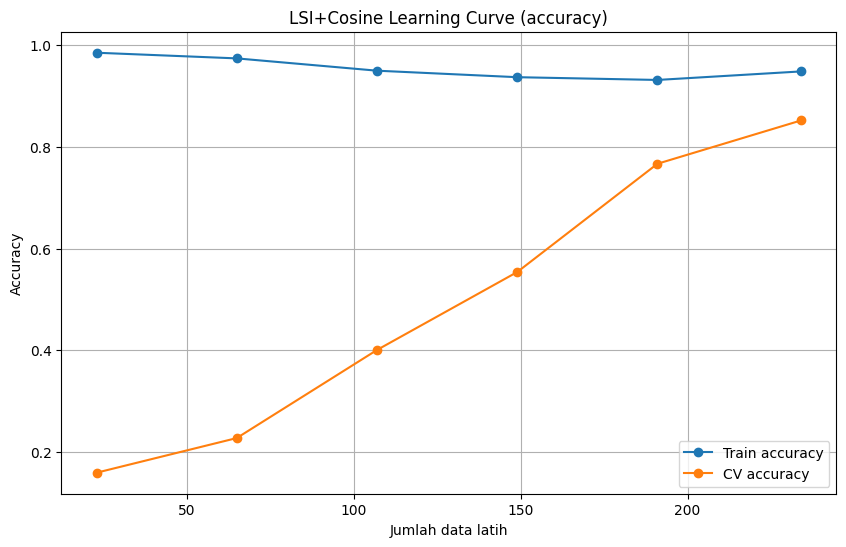

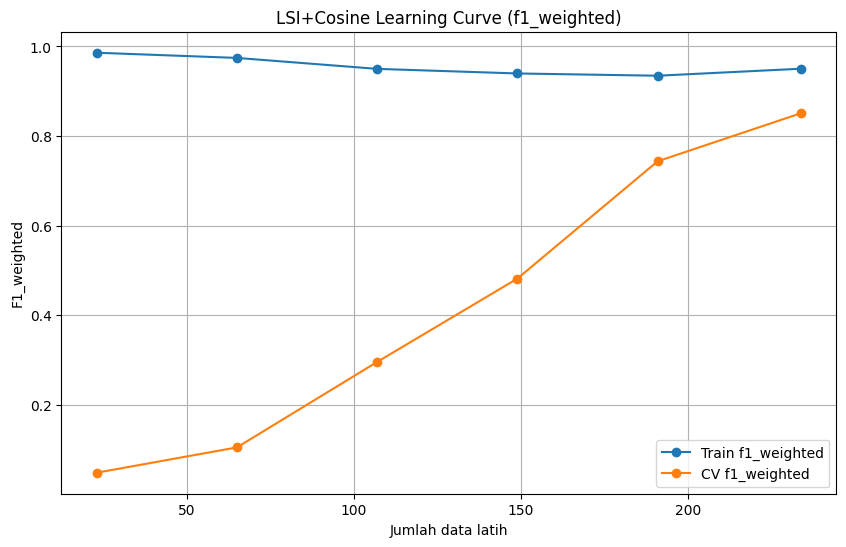

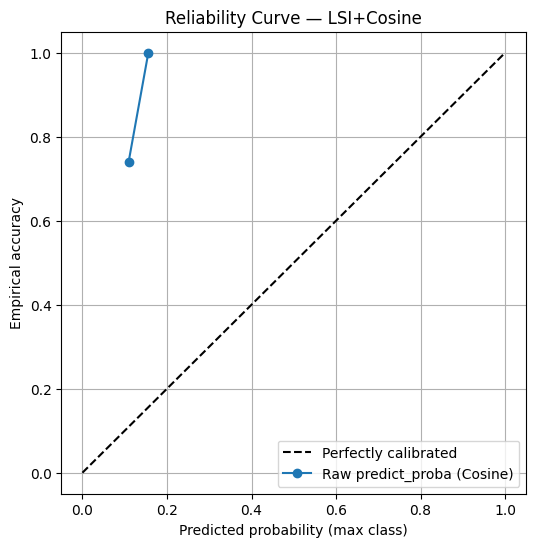

[INFO] Reliability Curve untuk LSI+Cosine berhasil diplot menggunakan predict_proba langsung.


In [ ]:
# ============================================================
# TAMBAHAN BARU: GRAFIK UNTUK LSI+Cosine Similarity (Centroid)
# ============================================================

# Buat pipeline dasar untuk Cosine tanpa oversampling (sesuai konfigurasi asli)
pipe_cos_no_sampling = make_lsi_pipeline(                                                                             #### Buat pipeline Cosine Centroid tanpa SMOTE
    ClassCentroidCosineClassifier(use_softmax=True),                                                                  #### Classifier Cosine Centroid
    n_components=SVD_COMPONENTS,                                                                                      #### Jumlah komponen LSI
    oversample=False                                                                                                  #### Set oversample ke False (sesuai aturan)
)

# a) Overfitting Curve — LSI+Cosine
# Karena Cosine Centroid tidak punya hyperparameter seperti K, gunakan variasi n_components SVD sebagai proxy
components_list = [100, 150, 200, 250, 300]                                                                           #### Variasi jumlah komponen LSI (sebagai proxy hyperparameter)
train_acc_cos, cv_acc_cos = [], []                                                                                    #### List untuk akurasi train dan CV
for n_comp in components_list:                                                                                        #### Loop melalui variasi komponen LSI
    # Buat pipeline baru dengan n_components berbeda
    mdl_cos = make_lsi_pipeline(                                                                                      #### Buat pipeline baru
        ClassCentroidCosineClassifier(use_softmax=True),                                                              #### Classifier
        n_components=n_comp,                                                                                          #### Jumlah komponen SVD yang berbeda
        oversample=False                                                                                              #### Tanpa SMOTE
    )
    mdl_cos.fit(corpus_main, labels)                                                                                  #### Latih model
    train_acc_cos.append(accuracy_score(labels, mdl_cos.predict(corpus_main)))                                        #### Hitung dan simpan akurasi train
    cv_acc_cos.append(cross_val_score(mdl_cos, corpus_main, labels, cv=cv, scoring='accuracy', n_jobs=-1).mean())     #### Hitung dan simpan rata-rata akurasi CV

plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(components_list, train_acc_cos, marker='o', label='Train Acc')                                               #### Plot akurasi train
plt.plot(components_list, cv_acc_cos, marker='o', label='CV Acc')                                                     #### Plot akurasi CV
plt.title('Overfitting Curve — LSI+Cosine')                                                                           #### Judul plot
plt.xlabel('Jumlah Komponen SVD (LSI)')                                                                               #### Label sumbu X
plt.ylabel('Akurasi')                                                                                                 #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# b) LSI+Cosine Learning Curve (accuracy)
train_sizes = np.linspace(0.1, 1.0, 6)                                                                                #### Daftar ukuran data latih (proporsi)
tr_sizes, tr_scores, cv_scores = learning_curve(                                                                      #### Hitung learning curve
    estimator=pipe_cos_no_sampling,                                                                                   #### Estimator Cosine Centroid
    X=corpus_main,                                                                                                    #### Data X
    y=labels,                                                                                                         #### Data Y
    train_sizes=train_sizes,                                                                                          #### Ukuran data latih
    cv=cv,                                                                                                            #### Strategi CV
    scoring='accuracy',                                                                                               #### Metrik skor
    n_jobs=-1                                                                                                         #### Gunakan semua core
)
plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(tr_sizes, tr_scores.mean(axis=1), marker='o', label='Train accuracy')                                        #### Plot akurasi train
plt.plot(tr_sizes, cv_scores.mean(axis=1), marker='o', label='CV accuracy')                                           #### Plot akurasi CV
plt.title('LSI+Cosine Learning Curve (accuracy)')                                                                     #### Judul plot
plt.xlabel('Jumlah data latih')                                                                                       #### Label sumbu X
plt.ylabel('Accuracy')                                                                                                #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# c) LSI+Cosine Learning Curve (f1_weighted)
tr_sizes, tr_scores, cv_scores = learning_curve(                                                                      #### Hitung learning curve (f1_weighted)
    estimator=pipe_cos_no_sampling,                                                                                   #### Estimator Cosine Centroid
    X=corpus_main,                                                                                                    #### Data X
    y=labels,                                                                                                         #### Data Y
    train_sizes=train_sizes,                                                                                          #### Ukuran data latih
    cv=cv,                                                                                                            #### Strategi CV
    scoring='f1_weighted',                                                                                            #### Metrik skor
    n_jobs=-1                                                                                                         #### Gunakan semua core
)
plt.figure(figsize=(10, 6))                                                                                           #### Buat figure plot
plt.plot(tr_sizes, tr_scores.mean(axis=1), marker='o', label='Train f1_weighted')                                     #### Plot F1 train
plt.plot(tr_sizes, cv_scores.mean(axis=1), marker='o', label='CV f1_weighted')                                        #### Plot F1 CV
plt.title('LSI+Cosine Learning Curve (f1_weighted)')                                                                  #### Judul plot
plt.xlabel('Jumlah data latih')                                                                                       #### Label sumbu X
plt.ylabel('F1_weighted')                                                                                             #### Label sumbu Y
plt.grid(True)                                                                                                        #### Tampilkan grid
plt.legend()                                                                                                          #### Tampilkan legenda
plt.show()                                                                                                            #### Tampilkan plot

# d) Reliability Curve — LSI+Cosine
try:                                                                                                                  #### Coba untuk menghitung dan memplot reliability curve
    y_proba_cal_cos = cross_val_predict(                                                                              #### Prediksi probabilitas CV
        pipe_cos_no_sampling, corpus_main, labels, cv=cv, method='predict_proba', n_jobs=-1
    )
    y_pred_cos = np.argmax(y_proba_cal_cos, axis=1)                                                                   #### Ambil kelas prediksi
    labels_arr = np.array([classes.index(c) for c in labels])                                                         #### Konversi label ke indeks numerik
    max_proba_cos = y_proba_cal_cos[np.arange(len(y_proba_cal_cos)), y_pred_cos]                                      #### Ambil probabilitas tertinggi
    correct_cos = (y_pred_cos == labels_arr).astype(int)                                                              #### Cek apakah prediksi benar

    bins = np.linspace(0.0, 1.0, 8)                                                                                   #### Definisikan batas bin
    bin_ids = np.digitize(max_proba_cos, bins) - 1                                                                    #### Tentukan bin ID
    x_bin_cos, y_bin_cos = [], []                                                                                     #### List untuk titik plot
    for b in range(len(bins) - 1):                                                                                    #### Loop melalui setiap bin
        idx = (bin_ids == b)                                                                                          #### Ambil indeks sampel di bin ini
        if idx.sum() == 0:                                                                                            #### Jika bin kosong
            continue                                                                                                  #### Lanjutkan
        x_bin_cos.append(max_proba_cos[idx].mean())                                                                   #### Rata-rata probabilitas prediksi (sumbu X)
        y_bin_cos.append(correct_cos[idx].mean())                                                                     #### Rata-rata akurasi empiris (sumbu Y)

    plt.figure(figsize=(6, 6))                                                                                        #### Buat figure plot
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')                                                     #### Plot garis kalibrasi sempurna
    plt.plot(x_bin_cos, y_bin_cos, marker='o', label='Raw predict_proba (Cosine)')                                    #### Plot reliability curve
    plt.xlabel('Predicted probability (max class)')                                                                   #### Label sumbu X
    plt.ylabel('Empirical accuracy')                                                                                  #### Label sumbu Y
    plt.title('Reliability Curve — LSI+Cosine')                                                                       #### Judul plot
    plt.legend()                                                                                                      #### Tampilkan legenda
    plt.grid(True)                                                                                                    #### Tampilkan grid
    plt.show()                                                                                                        #### Tampilkan plot
    print("[INFO] Reliability Curve untuk LSI+Cosine berhasil diplot menggunakan predict_proba langsung.")            #### Pesan sukses
except Exception as e:                                                                                                #### Tangani error
    print(f"[WARN] Reliability Curve untuk LSI+Cosine dilewati: {e!r}")                                               #### Pesan peringatan
    print("  - Penyebab umum: Data terlalu kecil atau error parallel processing.")                                    #### Info penyebab umum
    print("  - Solusi: Coba kurangi n_jobs=1 atau periksa ukuran dataset.")                                           #### Info solusi


In [ ]:
# ============================================================
# LATIH ULANG MODEL TERBAIK DI SELURUH DATA
# ============================================================

best_model_name = summary_df['F1-Weighted'].astype(float).idxmax()                                                    #### Ambil nama model terbaik berdasarkan F1-Weighted
best_final_model = clone(models[best_model_name]).fit(corpus_main, labels)                                            #### Kloning model terbaik, lalu latih ulang menggunakan seluruh data korpus
print(f"\nModel TERBAIK ({best_model_name}) dilatih ulang di seluruh data dan siap digunakan.")                       #### Tampilkan pesan konfirmasi

from google.colab import files                                                                                        #### Import modul 'files' dari Google Colab untuk fungsi upload

def klasifikasi_dokumen_baru():                                                                                       #### Definisikan fungsi untuk klasifikasi dokumen PDF baru
    print("\nSilakan upload PDF baru...")                                                                             #### Tampilkan pesan instruksi upload
    uploaded = files.upload()                                                                                         #### Panggil fungsi upload file, akan menunggu input pengguna
    if not uploaded:                                                                                                  #### Cek jika tidak ada file yang diupload
        return                                                                                                        #### Keluar dari fungsi jika tidak ada file
    for fn, content in uploaded.items():                                                                              #### Loop melalui setiap file yang diupload (fn=nama file, content=isi file)
        path = f"/content/{fn}"                                                                                       #### Tentukan path sementara di lingkungan Colab
        with open(path, 'wb') as f:                                                                                   #### Buka file baru dalam mode binary write
            f.write(content)                                                                                          #### Tulis konten binary dari file yang diupload ke path sementara

        teks = ekstrak_teks_pdf(path)                                                                                 #### Ekstrak teks dari PDF menggunakan fungsi yang sudah didefinisikan
        if teks and teks.strip():                                                                                     #### Cek jika ekstraksi teks berhasil (tidak kosong)
            teks_final = teks + " " + tokens_namafile(path)                                                           #### Gabungkan teks yang diekstrak dengan token dari nama file
            teks_bersih = pra_proses_teks(teks_final)                                                                 #### Lakukan pra-proses (lower case, stop word removal, stemming)
            proba = best_final_model.predict_proba([teks_bersih])[0]                                                  #### Prediksi probabilitas kelas menggunakan model terbaik
            pred_idx = int(np.argmax(proba))                                                                          #### Ambil indeks kelas dengan probabilitas tertinggi
            pred_label = classes[pred_idx]                                                                            #### Dapatkan label kelas (nama kategori) dari indeks

            print(f"\nFile: {fn}")                                                                                    #### Tampilkan nama file
            print(f"Model: {best_model_name}")                                                                        #### Tampilkan nama model yang digunakan
            print(f"Prediksi: {pred_label} (skor: {proba[pred_idx]:.3f})")                                            #### Tampilkan hasil prediksi utama dan skornya

            order = np.argsort(proba)[::-1][:3]                                                                       #### Urutkan indeks probabilitas secara descending dan ambil 3 teratas
            print("Top-3:")                                                                                           #### Header untuk Top-3
            for i in order:                                                                                           #### Loop melalui 3 indeks teratas
                print(f"  - {classes[i]}: {proba[i]:.3f}")                                                            #### Tampilkan label dan probabilitas Top-3
        else:                                                                                                         #### Jika gagal ekstrak teks
            print(f"Gagal ekstrak teks dari {fn}.")                                                                   #### Tampilkan pesan gagal
        try:                                                                                                          #### Mulai blok try untuk menghapus file
            os.remove(path)                                                                                           #### Hapus file sementara setelah selesai
        except:                                                                                                       #### Jika terjadi error saat menghapus
            pass                                                                                                      #### Lewati/abaikan error

# Panggil fungsi ini untuk uji dokumen baru
klasifikasi_dokumen_baru()                                                      # Uncomment jika ingin langsung jalankan upload #### Panggil fungsi untuk memulai proses upload dan klasifikasi



Model TERBAIK (LSI+Cosine Similarity (Centroid)) dilatih ulang di seluruh data dan siap digunakan.

Silakan upload PDF baru...


Saving J Statiska.pdf to J Statiska.pdf

File: J Statiska.pdf
Model: LSI+Cosine Similarity (Centroid)
Prediksi: penelitian_publikasi karya (skor: 0.104)
Top-3:
  - penelitian_publikasi karya: 0.104
  - pendidikan_bahan ajar: 0.098
  - penelitian_penelitian: 0.094
